# Time Series Forecasting

#### Objective
- Build an ML model to train on time-series data.
- Perform EDA, Feature Engineering, and Model Building.
- Forecast 1 year in future of the data.
- Save the model for future tuning.

#### Data
- Over 10 years of hourly energy consumption data from PJM in Megawatts
- PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.
- The hourly power consumption data comes from PJM's website and are in megawatts (MW).
- The regions have changed over the years so data may only appear for certain dates per region.



In [4]:
# %pip install -r requirements.txt

In [5]:
# %pip freeze

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

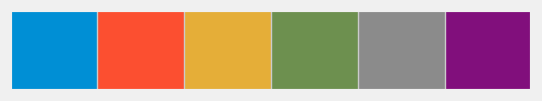

In [7]:
sns.palplot(color_pal)

In [8]:
# read csv and set datetime as index
df = pd.read_csv('./data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [9]:
df.index.dtype

dtype('<M8[ns]')

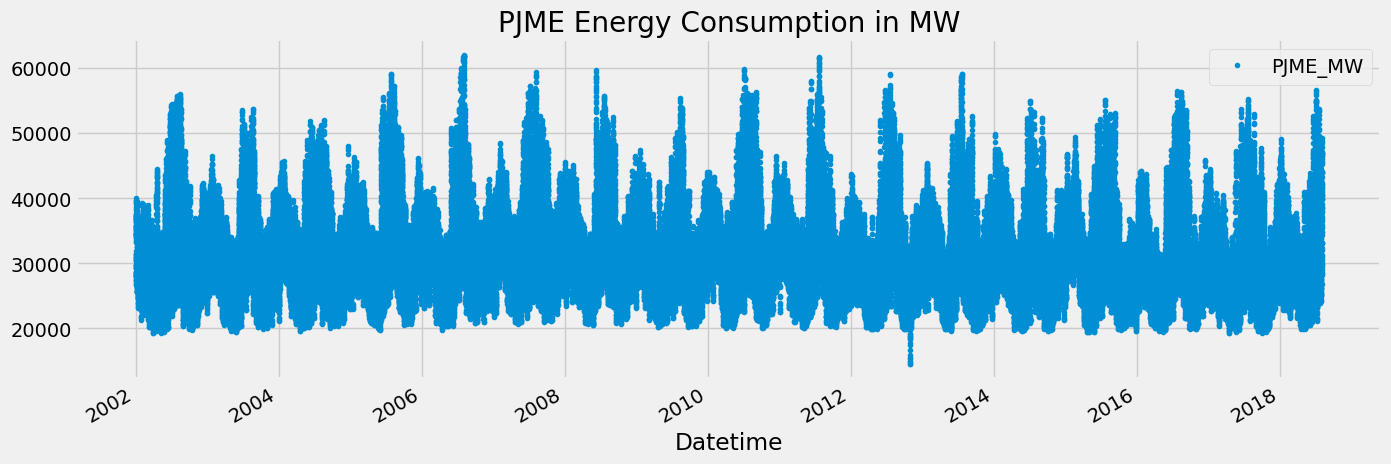

In [10]:
# preview data

df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Consumption in MW')

plt.show()

In [11]:
# last date
df.index.max()

Timestamp('2018-08-03 00:00:00')

### Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

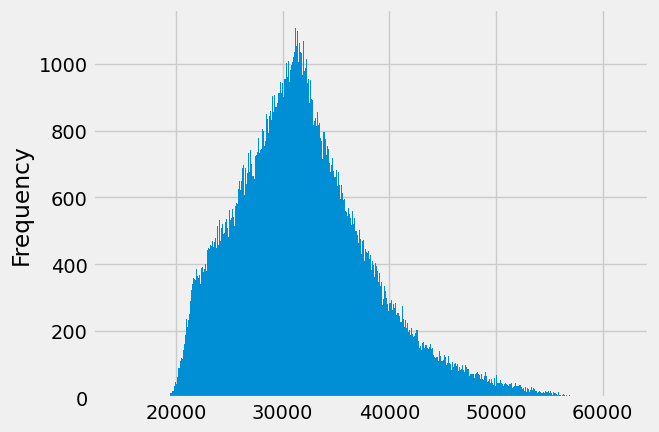

In [12]:
# spot outlier by visual
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outlier (<20000)'}, xlabel='Datetime'>

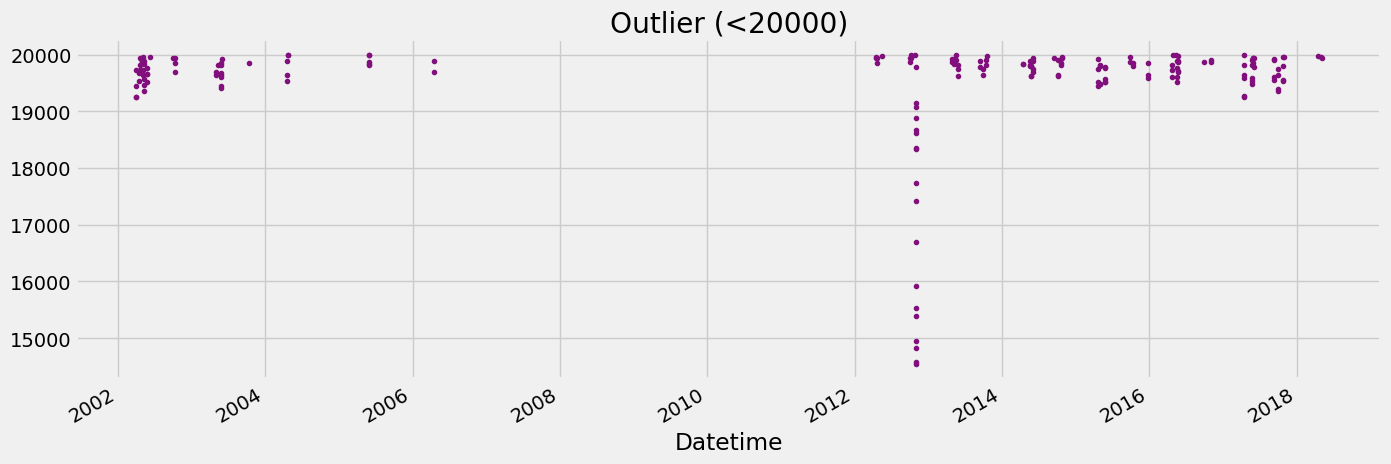

In [13]:
# lower end outlier boundary = 20,000
df.query('PJME_MW < 20_000')['PJME_MW'].plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[5],
                                             title='Outlier (<20000)')

<Axes: title={'center': 'Outliers (<19000)'}, xlabel='Datetime'>

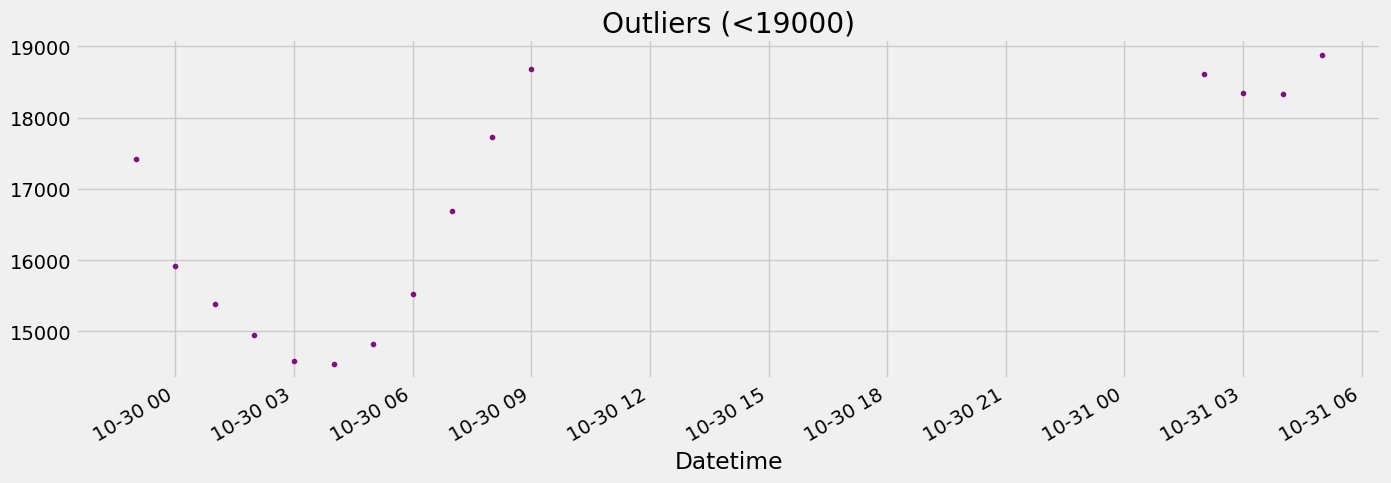

In [14]:
# better lower end outlier boundary = 19,000
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[5],
                                             title='Outliers (<19000)')

In [15]:
# create a df copy without lower outlier
df = df.query('PJME_MW > 19_000').copy()

### Train / Test Split
- Test set: 2015-01-01 - 2018-08-03
- Train set: before 2015

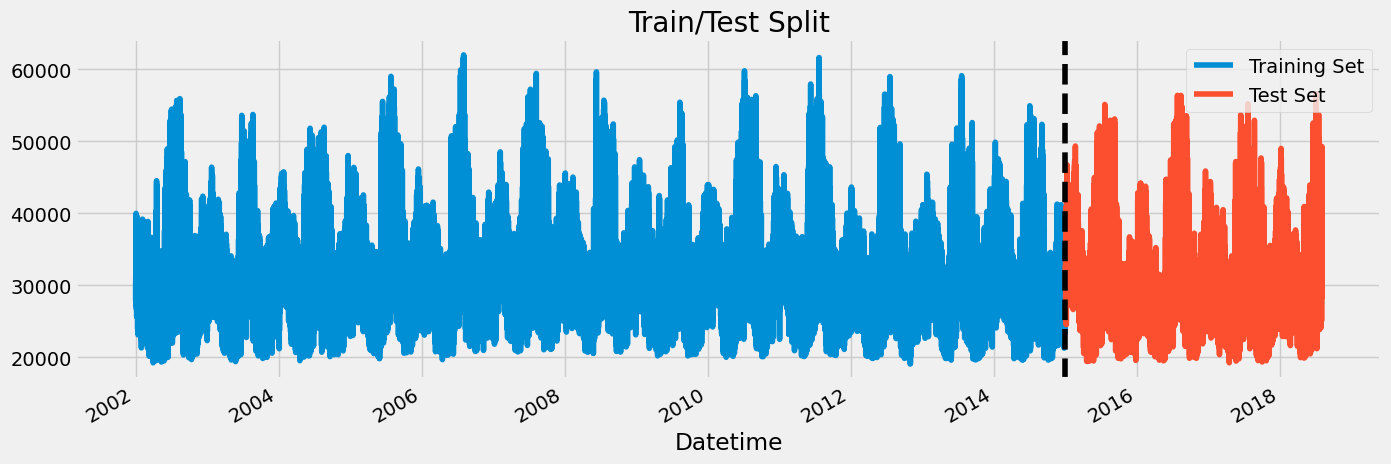

In [16]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, 
           label='Training Set', 
           title='Train/Test Split')

test.plot(ax=ax, 
          label='Test Set')

ax.axvline('01-01-2015', 
           color='black',
           ls='--')

ax.legend(['Training Set', 'Test Set'])

plt.show()

## Time Series Cross Validation

- Perform a 5-fold cross-validation
- Each fold of the validation set is 1 year (i.e. each validation round predicts out of 1 year in the future)
- 24-hour gap between each training and validation set each time
- Make sure to sort the datetime in order first

In [17]:
# TimeSeriesSplit is a generator, and can be looped over by n_splits times
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# sort the datetime in order
df = df.sort_index()

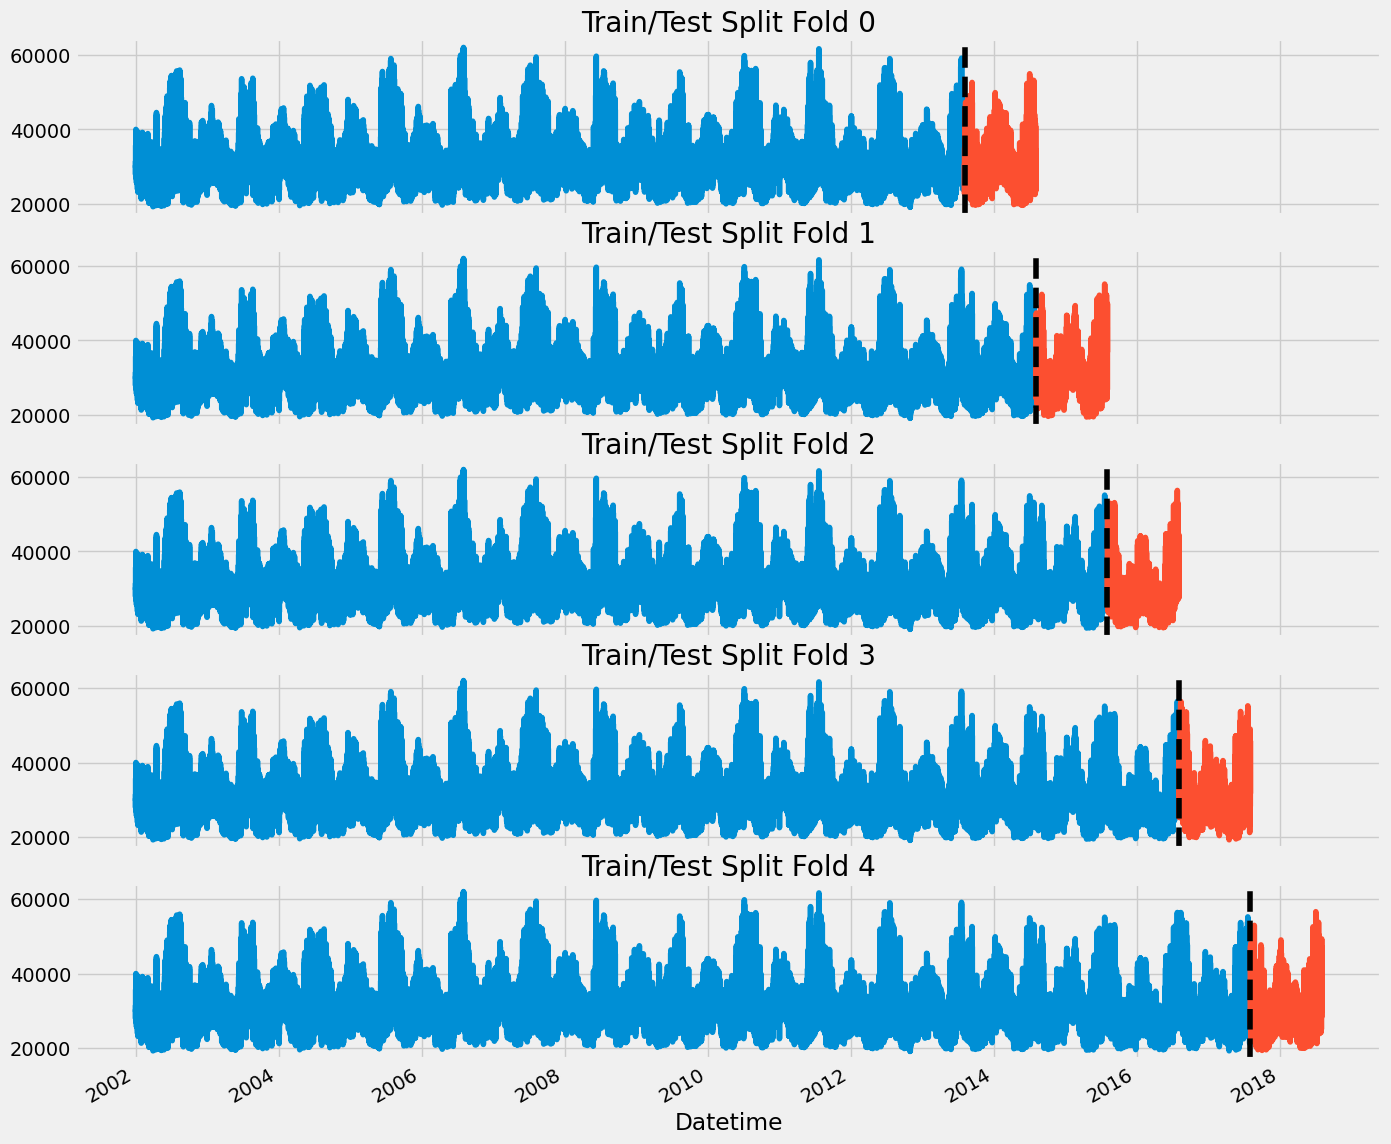

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    val_train = df.iloc[train_idx]
    val_test = df.iloc[val_idx]
    
    val_train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}')
    
    val_test['PJME_MW'].plot(ax=axs[fold],
                         label='Validation Set')
    axs[fold].axvline(val_test.index.min(), color='black', ls='--')

plt.show()

### Feature Engineering and EDA
- Create different datetime measuring units as features

In [19]:
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['is_month_start'] = df.index.is_month_start
    df['is_month_end'] = df.index.is_month_end
    df['is_quarter_start'] = df.index.is_quarter_start
    df['is_quarter_end'] = df.index.is_quarter_end
    df['is_year_start'] = df.index.is_year_start
    df['is_year_end'] = df.index.is_year_end
    df['days_in_month'] = df.index.days_in_month
    df['is_leap_year'] = df.index.is_leap_year
    df['elapsed_days'] = (df.index - df.index.min()).days
    # df['weekday_name'] = df.index.day_name()
    # df['month_name'] = df.index.month_name()
    df['is_weekend'] = df['weekday'].apply(lambda x: x >= 5)
    df['is_weekday'] = ~df['is_weekend']
    df['days_till_month_end'] = df['days_in_month'] - df['day_of_month']
    df['days_since_month_start'] = df['day_of_month'] - 1
    df['week_of_month'] = (df['day_of_month'] - 1) // 7 + 1
    df['weekday_of_month'] = (df['day_of_month'] - 1) % 7 + 1
    df['business_days_in_month'] = df.index.to_series().apply(lambda x: np.busday_count(np.datetime64(x.replace(day=1).strftime('%Y-%m-%d')), np.datetime64((x.replace(day=x.days_in_month) + pd.DateOffset(days=1)).strftime('%Y-%m-%d'))))
    df['business_day_of_month'] = df.index.to_series().apply(lambda x: np.busday_count(np.datetime64(x.replace(day=1).strftime('%Y-%m-%d')), np.datetime64(x.strftime('%Y-%m-%d'))))
    df['days_since_first_day_of_year'] = df['day_of_year'] - 1
    df['days_remaining_in_year'] = (df.index + pd.offsets.YearEnd(0)).dayofyear - df['day_of_year']
    ## optional 
    # df['days_to_next_holiday'] = df.index.to_series().apply(lambda x: (x + pd.DateOffset(days=1)).to_period('D').start_time)
    # df['days_since_last_holiday'] = df.index.to_series().apply(lambda x: (x - pd.DateOffset(days=1)).to_period('D').end_time)
    
    return df
    
df = create_features(df)

### Visualize our Feature / Target Relationship¶

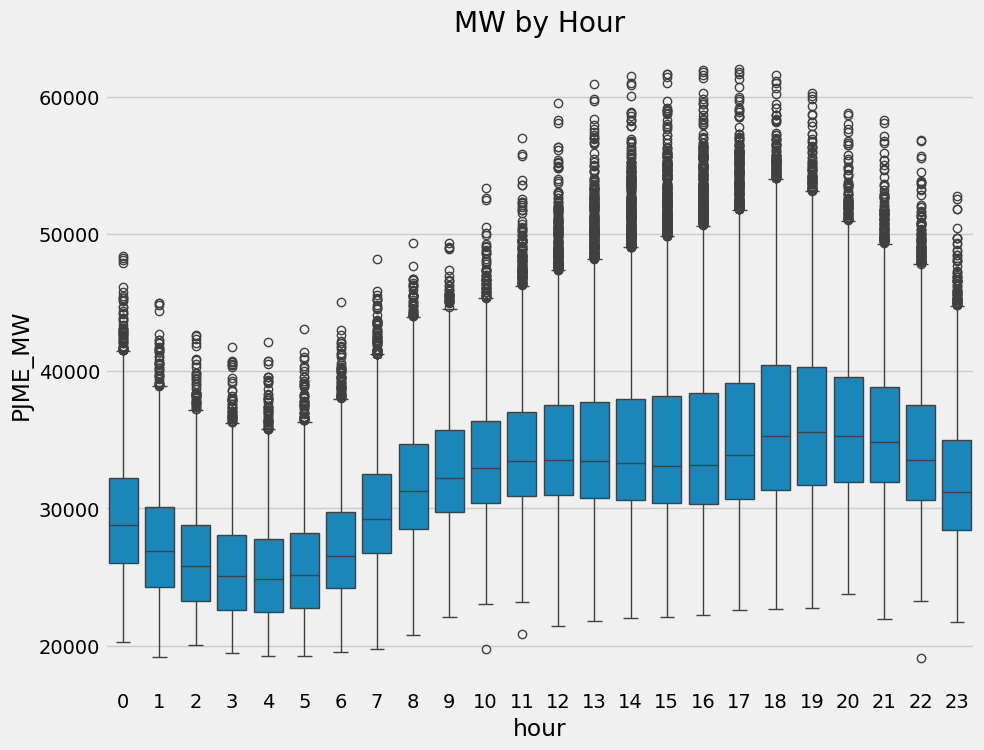

In [20]:
# Hour vs PJME_MW
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

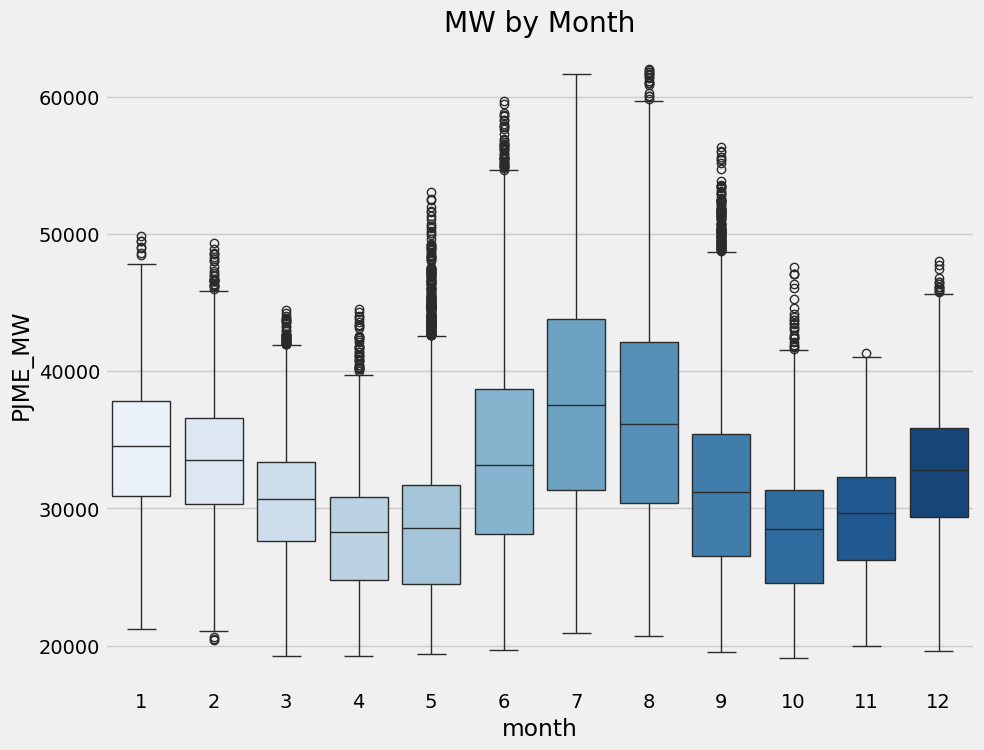

In [21]:
# Month vs PJME_MW
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

Observation:
- July and August have the highest energy consumption relative to other months, most likely due to summer air conditioning and other related usage.
- Jan, Feb and Dec have are second to top range of energy consumption, mostly due to winter heating consumption but not all states in US need it.

### Adding Lag Features
- Adding values of previous time steps in the time series
- Help capturing the autocorrelation present in the data, which is the relationship between the current value and its past values.

In [22]:
# helper function
# lags in hour (unit of time in df)
def create_lag_hour(df, max_lags_hr):
    for i in range(1, max_lags_hr+1):
        df[f'hour_lag{i}'] = df['PJME_MW'].shift(i)
    return df

In [23]:
def create_lag_year(df, max_lag_yr):
    
    # remove duplicate due to daylight saving and keep the first one 
    df = df[~df.index.duplicated(keep='first')].copy()

    # create dictionary {datetime: PJME_MW}
    target_map = df['PJME_MW'].to_dict()
    
    for i in range(1, max_lag_yr+1):
        
        # Subtract years directly using DateOffset
        lagged_dates = (df.index - pd.DateOffset(years=i))
        df[f'year_lag{i}'] = lagged_dates.map(target_map)
        
    return df

In [24]:
df = create_lag_year(df, max_lag_yr=3)

In [25]:
# checking lag feature, notice that for data on Feb 29 of a leap year, the lag data refers to Feb 28.

# leap years
print(f'leap years = {set(list(df.query('is_leap_year==True').year.values))}\n')

df.loc[['2008-2-29 8:0:0', '2008-2-28 8:0:0', '2007-2-28 8:0:0', '2006-2-28 8:0:0'], ['PJME_MW', 'year_lag1', 'year_lag2', 'year_lag3']]

leap years = {2008, 2016, 2012, 2004}



,PJME_MW,year_lag1,year_lag2,year_lag3
Datetime,,,,
2008-02-29 08:00:00,41765.0,36988.0,38823.0,36857.0
2008-02-28 08:00:00,41414.0,36988.0,38823.0,36857.0
2007-02-28 08:00:00,36988.0,38823.0,36857.0,30542.0
2006-02-28 08:00:00,38823.0,36857.0,30542.0,36725.0


In [26]:
df.tail()

,PJME_MW,year,month,day_of_month,hour,weekday,day_of_year,week_of_year,quarter,is_month_start,...,days_since_month_start,week_of_month,weekday_of_month,business_days_in_month,business_day_of_month,days_since_first_day_of_year,days_remaining_in_year,year_lag1,year_lag2,year_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,2018,8,2,20,3,214,31,3,False,...,1,1,2,23,1,213,151,39352.0,41056.0,41451.0
2018-08-02 21:00:00,43256.0,2018,8,2,21,3,214,31,3,False,...,1,1,2,23,1,213,151,38699.0,40151.0,40339.0
2018-08-02 22:00:00,41552.0,2018,8,2,22,3,214,31,3,False,...,1,1,2,23,1,213,151,37346.0,38662.0,39057.0
2018-08-02 23:00:00,38500.0,2018,8,2,23,3,214,31,3,False,...,1,1,2,23,1,213,151,34555.0,35583.0,36074.0
2018-08-03 00:00:00,35486.0,2018,8,3,0,4,215,31,3,False,...,2,1,3,23,2,214,150,31646.0,32181.0,32928.0


### Training Using Cross Validation

In [27]:
# list features to train the model
FEATURES = df.columns.tolist()
FEATURES.remove('PJME_MW')
FEATURES

['year',
 'month',
 'day_of_month',
 'hour',
 'weekday',
 'day_of_year',
 'week_of_year',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'is_year_start',
 'is_year_end',
 'days_in_month',
 'is_leap_year',
 'elapsed_days',
 'is_weekend',
 'is_weekday',
 'days_till_month_end',
 'days_since_month_start',
 'week_of_month',
 'weekday_of_month',
 'business_days_in_month',
 'business_day_of_month',
 'days_since_first_day_of_year',
 'days_remaining_in_year',
 'year_lag1',
 'year_lag2',
 'year_lag3']

In [28]:
# TimeSeriesSplit is a generator, and can be looped over by n_splits times
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# sort the datetime in order
df = df.sort_index()

preds = []
scores = []

for fold, (train_dix, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)
    
    FEATURES = df.columns.tolist()
    FEATURES.remove('PJME_MW')
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[0]	validation_0-rmse:32462.73864	validation_1-rmse:31956.66243
[100]	validation_0-rmse:12496.35523	validation_1-rmse:11996.67493
[200]	validation_0-rmse:5797.69121	validation_1-rmse:5381.50334
[300]	validation_0-rmse:3967.75979	validation_1-rmse:3791.05010
[400]	validation_0-rmse:3540.96339	validation_1-rmse:3582.53691
[426]	validation_0-rmse:3493.65503	validation_1-rmse:3605.33265
[0]	validation_0-rmse:32462.73864	validation_1-rmse:32138.02671
[100]	validation_0-rmse:12496.35523	validation_1-rmse:12306.07074
[200]	validation_0-rmse:5797.69121	validation_1-rmse:5696.31882
[300]	validation_0-rmse:3967.75979	validation_1-rmse:3908.60554
[400]	validation_0-rmse:3540.96339	validation_1-rmse:3523.63678
[500]	validation_0-rmse:3406.62616	validation_1-rmse:3501.13808
[506]	validation_0-rmse:3401.02902	validation_1-rmse:3502.42081
[0]	validation_0-rmse:32462.73864	validation_1-rmse:31078.82223
[100]	validation_0-rmse:12496.35523	validation_1-rmse:11242.69382
[200]	validation_0-rmse:5797.69121

In [29]:
scores

[3568.6870271100743,
 3490.386840535406,
 3448.467254524001,
 3827.9038181274,
 4139.035618791446]

In [30]:
preds

[array([40366.348, 39768.5  , 39768.5  , ..., 37247.434, 37115.957,
        35751.97 ], dtype=float32),
 array([37584.316, 36345.305, 34627.984, ..., 41226.344, 40691.355,
        40901.46 ], dtype=float32),
 array([38182.03 , 35609.91 , 29578.662, ..., 40422.16 , 39792.1  ,
        38436.71 ], dtype=float32),
 array([37969.68 , 31986.166, 29863.902, ..., 41772.297, 40421.758,
        37040.19 ], dtype=float32),
 array([29268.723, 27841.127, 26916.05 , ..., 39779.098, 36500.156,
        29120.799], dtype=float32)]

In [31]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds: 3694.8961
Fold scores:[3568.6870271100743, 3490.386840535406, 3448.467254524001, 3827.9038181274, 4139.035618791446]


### Feature Importance
- visualize which features are more useful in the model tuning

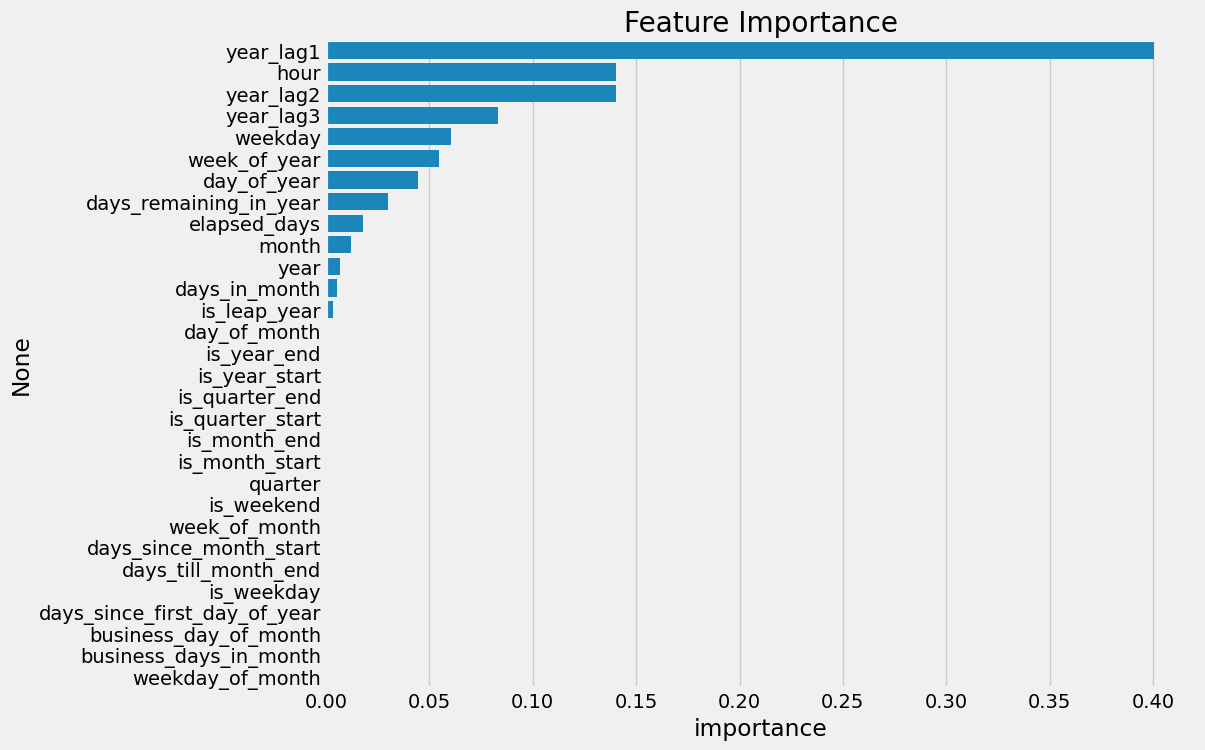

In [32]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fig, ax = plt.subplots(figsize=(10, 8))

sorted_fi = fi.sort_values('importance', ascending=False)
sns.barplot(x=sorted_fi['importance'], y=sorted_fi.index, ax=ax)

ax.set_title('Feature Importance')

plt.show()

Observation:
- 1 year lag feature is the most important feature.
- many of the boolean's features are not useful in the model.

### Predicting the Future
- Retraining on all the data
- Predict the future with an empty dataframe for future date ranges with feature engineering


In [33]:
# Retrain on all data
df = create_features(df)

FEATURES = df.columns.tolist()
FEATURES.remove('PJME_MW')
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32404.68576
[100]	validation_0-rmse:12481.21566
[200]	validation_0-rmse:5815.19117
[300]	validation_0-rmse:4006.38086
[400]	validation_0-rmse:3587.06145
[499]	validation_0-rmse:3458.05451


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [34]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [35]:
# Create future dataframe until 2019-08-01

future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)

# indicate it's future
future_df['isFuture'] = True
df['isFuture'] = False
df = df.sort_index()
future_df = future_df.sort_index()
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lag_year(df_and_future, max_lag_yr=3)

In [36]:
future_df.index.max()

Timestamp('2019-08-01 00:00:00')

In [37]:
df_and_future.index.max()

Timestamp('2019-08-01 00:00:00')

In [38]:
future_w_features_df = df_and_future.query('isFuture').copy()

In [39]:
future_w_features_df.head()

,PJME_MW,year,month,day_of_month,hour,weekday,day_of_year,week_of_year,quarter,is_month_start,...,week_of_month,weekday_of_month,business_days_in_month,business_day_of_month,days_since_first_day_of_year,days_remaining_in_year,year_lag1,year_lag2,year_lag3,isFuture
2018-08-03 01:00:00,NaN,2018,8,3,1,4,215,31,3,False,...,1,3,23,2,214,150,29189.0,29462.0,30290.0,True
2018-08-03 02:00:00,NaN,2018,8,3,2,4,215,31,3,False,...,1,3,23,2,214,150,27584.0,27717.0,28490.0,True
2018-08-03 03:00:00,NaN,2018,8,3,3,4,215,31,3,False,...,1,3,23,2,214,150,26544.0,26540.0,27348.0,True
2018-08-03 04:00:00,NaN,2018,8,3,4,4,215,31,3,False,...,1,3,23,2,214,150,26012.0,25912.0,26805.0,True
2018-08-03 05:00:00,NaN,2018,8,3,5,4,215,31,3,False,...,1,3,23,2,214,150,26187.0,26030.0,26996.0,True


### Predict the future

In [40]:
future_w_features_df['pred'] = reg.predict(future_w_features_df[FEATURES])

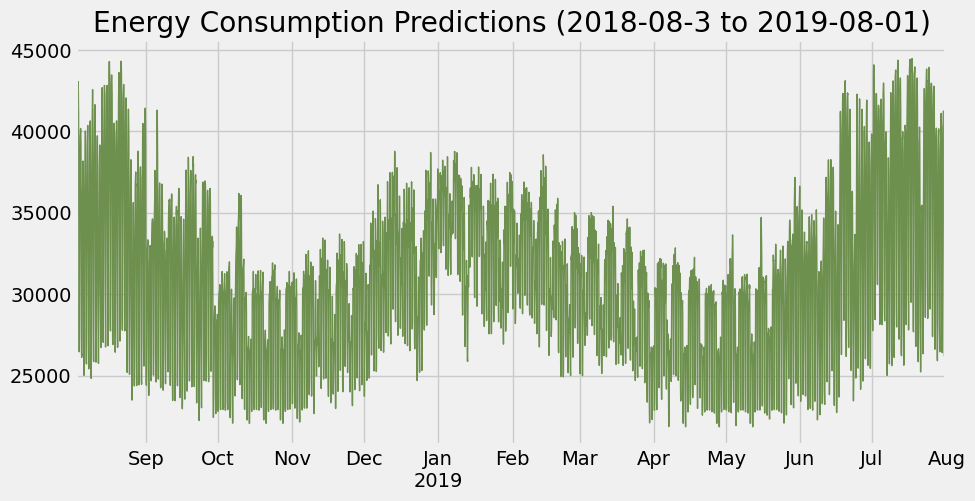

In [41]:
future_w_features_df['pred'].plot(figsize=(10,5),
                                  color=color_pal[3],
                                  ms=1,
                                  lw=1,
                                  title='Energy Consumption Predictions (2018-08-3 to 2019-08-01)')
plt.show()

### Saving the Model

In [42]:
reg.save_model('model.json')

<Axes: title={'center': 'New Model - Energy Consumption Predictions (2018-08-3 to 2019-08-01)'}>

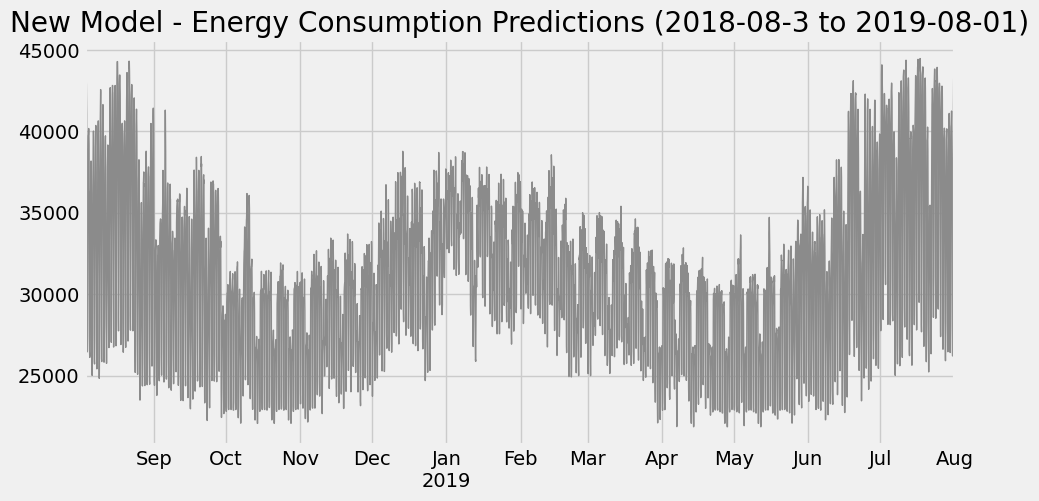

In [43]:
# load saved model 
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features_df['pred'] = reg_new.predict(future_w_features_df[FEATURES])
future_w_features_df['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='New Model - Energy Consumption Predictions (2018-08-3 to 2019-08-01)')